In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

from scipy.signal import detrend
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

sns.set(rc={'figure.figsize':(6., 3.336)})
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
df = pd.read_csv('cultivable_pca.csv')
df['Date'] = pd.to_datetime(df['Date'])

features = df.iloc[:, 13:]
cols = features.columns.tolist()

In [4]:
emi2 = [18, 59, 57]
multitask = [40, 36, 25, 52, 1, 21, 35, 31, 22, 51]

ds = df[[cols[i] for i in emi2] + ['anomalia_emiliani2']]

ds['anomalia_emiliani2'] = detrend(ds['anomalia_emiliani2'])
ds['anomalia_emiliani2_t'] = ds['anomalia_emiliani2'].shift(1)
ds['anomalia_emiliani2_t-1'] = ds['anomalia_emiliani2'].shift(2)


columns = ds.columns.tolist()
for col in columns[:3]:
    for i in range(1,24):
        ds[col+'_t-'+str(i)] = ds[col].shift(i)
        
for col in columns[3:4]:
    for i in range(3,26):
        ds[col+'_t-'+str(i-1)] = ds[col].shift(i)
        
ds = ds.iloc[25:].reset_index(drop=True)

pcs = ds.filter(regex='PC')
anomalia = ds.filter(regex='emiliani2_t')
ds = ds[pcs.columns.tolist() + anomalia.columns.tolist()[1:] + anomalia.columns.tolist()[0:1]]


# divide into train/test
train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

scaler = StandardScaler()
scaler.fit(train)
ds[ds.columns] = scaler.transform(ds[ds.columns])

train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

# Modelli

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
from sklearn.ensemble import ExtraTreesRegressor

In [7]:
def feed_forward():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='mse',
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  
  return model

In [8]:
def rnn(HISTORY_SIZE, OUT_STEPS, n_features):
  model = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(
        units=64,
        input_shape=(HISTORY_SIZE, n_features),
        return_sequences=False # True nel multitask
      ),
     #tf.keras.layers.Lambda(lambda x: x[:, -pred_steps:, :]), #Select last N from output [multitask]
     tf.keras.layers.Dense(OUT_STEPS)
     ])

  model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.metrics.MeanAbsoluteError()]
  )

  return model

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Variabili [t]

In [10]:
train_val = pd.concat([train,validation])

In [11]:
linear_val = LinearRegression()
linear = LinearRegression()
linear_val.fit(train.iloc[:, :3].values, train.iloc[:, -1].values)

LinearRegression()

In [12]:
linear.fit(train_val.iloc[int(len(train_val)*0.2):, :3].values, train_val.iloc[int(len(train_val)*0.2):, -1].values)

LinearRegression()

In [13]:
from hypopt import GridSearch

ext = ExtraTreesRegressor()

opt = GridSearch(model = ext, param_grid = random_grid)

opt.fit(train.iloc[:, :3].values, train.iloc[:, -1].values, validation.iloc[:, :3].values, validation.iloc[:, -1].values)

100%|██████████| 480/480 [00:35<00:00, 13.47it/s]


ExtraTreesRegressor(bootstrap=True, max_depth=10, max_features='sqrt',
                    min_samples_leaf=2, n_estimators=200, random_state=0)

In [14]:
best_rf = opt.best_estimator_
best_rf.fit(train_val.iloc[int(len(train_val)*0.2):, :3].values, train_val.iloc[int(len(train_val)*0.2):, -1].values)

ExtraTreesRegressor(bootstrap=True, max_depth=10, max_features='sqrt',
                    min_samples_leaf=2, n_estimators=200, random_state=0)

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

ffnn_val = feed_forward()

hist_val = ffnn_val.fit(train.iloc[:, :3].values, train.iloc[:, -1].values, shuffle=False, epochs=100, validation_data=(validation.iloc[:, :3].values, validation.iloc[:, -1].values), callbacks=callback)

ffnn = feed_forward()
ffnn = ffnn_val
hist = ffnn.fit(train_val.iloc[int(len(train_val)*0.2):, :3].values, train_val.iloc[int(len(train_val)*0.2):, -1].values, shuffle=False, epochs=50)

Epoch 1/100
19/19 [==============================] - 1s 17ms/step - loss: 1.5725 - mean_absolute_error: 0.9305 - val_loss: 0.6805 - val_mean_absolute_error: 0.6810
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 1.3432 - mean_absolute_error: 0.8528 - val_loss: 0.6393 - val_mean_absolute_error: 0.6632
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 1.1983 - mean_absolute_error: 0.7961 - val_loss: 0.6210 - val_mean_absolute_error: 0.6509
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0987 - mean_absolute_error: 0.7513 - val_loss: 0.6172 - val_mean_absolute_error: 0.6438
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0325 - mean_absolute_error: 0.7219 - val_loss: 0.6217 - val_mean_absolute_error: 0.6417
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9896 - mean_absolute_error: 0.7076 - val_loss: 0.6295 - val_mean_absolute_error: 0.6440
Epoch 7/100
19/19 [==

In [16]:
linear_mae = mean_absolute_error(train.iloc[:, -1].values, linear_val.predict(train.iloc[:, :3].values))
rf_mae = mean_absolute_error(train.iloc[:, -1].values, opt.predict(train.iloc[:, :3].values))
ffnn_mae = mean_absolute_error(train.iloc[:, -1].values, ffnn_val.predict(train.iloc[:, :3].values))

In [17]:
linear_mse = mean_squared_error(train.iloc[:, -1].values, linear_val.predict(train.iloc[:, :3].values))
rf_mse = mean_squared_error(train.iloc[:, -1].values, opt.predict(train.iloc[:, :3].values))
ffnn_mse = mean_squared_error(train.iloc[:, -1].values, ffnn_val.predict(train.iloc[:, :3].values))

linear_mse, rf_mse, ffnn_mse

(0.9399550778602372, 0.7358426587847849, 0.8728851176222836)

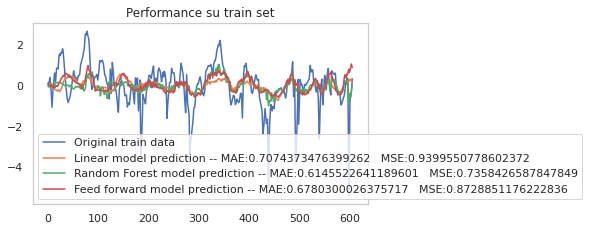

In [18]:
plt.title("Performance su train set")

plt.plot(train.iloc[:, -1].values, label='Original train data')
plt.plot(linear_val.predict(train.iloc[:, :3].values), label='Linear model prediction -- MAE:' + str(linear_mae) + '   MSE:' + str(linear_mse))
plt.plot(opt.predict(train.iloc[:, :3].values), label='Random Forest model prediction -- MAE:' + str(rf_mae) + '   MSE:' + str(rf_mse))
plt.plot(ffnn_val.predict(train.iloc[:, :3].values), label='Feed forward model prediction -- MAE:' + str(ffnn_mae) + '   MSE:' + str(ffnn_mse))
plt.legend()
plt.show()

In [19]:
linear_mae = mean_absolute_error(validation.iloc[:, -1].values, linear_val.predict(validation.iloc[:, :3].values))
rf_mae = mean_absolute_error(validation.iloc[:, -1].values, opt.predict(validation.iloc[:, :3].values))
ffnn_mae = mean_absolute_error(validation.iloc[:, -1].values, ffnn_val.predict(validation.iloc[:, :3].values))

In [20]:
linear_mse = mean_squared_error(validation.iloc[:, -1].values, linear_val.predict(validation.iloc[:, :3].values))
rf_mse = mean_squared_error(validation.iloc[:, -1].values, opt.predict(validation.iloc[:, :3].values))
ffnn_mse = mean_squared_error(validation.iloc[:, -1].values, ffnn_val.predict(validation.iloc[:, :3].values))

linear_mse, rf_mse, ffnn_mse

(0.6582731402105843, 0.5331231147551242, 0.6639122098513375)

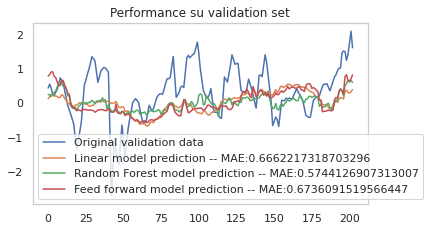

In [21]:
plt.title("Performance su validation set")

plt.plot(validation.iloc[:, -1].values, label='Original validation data')
plt.plot(linear_val.predict(validation.iloc[:, :3].values), label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(validation.iloc[:, :3].values), label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(validation.iloc[:, :3].values), label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

In [22]:
linear_mae = mean_absolute_error(test.iloc[:, -1].values, linear.predict(test.iloc[:, :3].values))
rf_mae = mean_absolute_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :3].values))
ffnn_mae = mean_absolute_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :3].values))

In [23]:
linear_mae, rf_mae, ffnn_mae

(0.4667189811071308, 0.4415261317662535, 0.391372371252827)

In [24]:
linear_mse = mean_squared_error(test.iloc[:, -1].values, linear.predict(test.iloc[:, :3].values))
rf_mse = mean_squared_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :3].values))
ffnn_mse = mean_squared_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :3].values))

linear_mse, rf_mse, ffnn_mse

(0.34496585743416436, 0.29314452699790106, 0.25034885289240477)

In [25]:
sqrt(linear_mse), sqrt(rf_mse), sqrt(ffnn_mse)

(0.5873379414222824, 0.5414282288520806, 0.5003487312788999)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


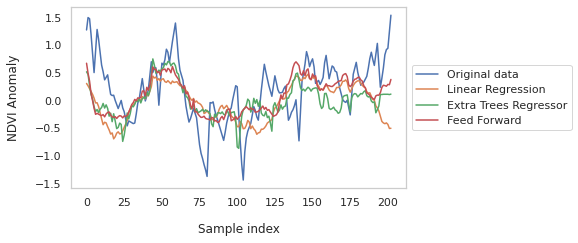

In [26]:
#plt.title("Performance su test set")

plt.plot(test.iloc[:, -1].values, label='Original data')
plt.plot(linear.predict(test.iloc[:, :3].values), label='Linear Regression')
plt.plot(best_rf.predict(test.iloc[:, :3].values), label='Extra Trees Regressor')
plt.plot(ffnn.predict(test.iloc[:, :3].values), label='Feed Forward ')
plt.xlabel('Sample index',labelpad=15)
plt.ylabel('NDVI Anomaly',labelpad=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('imgs/regression_no+serie+storica+var.eps', format='eps', bbox_inches='tight')
plt.show()


# Variabili serie storica

In [27]:
train_val = pd.concat([train,validation])
linear = LinearRegression()
linear_val = LinearRegression()
linear_val.fit(train.iloc[:, :72].values, train.iloc[:, -1].values)

linear.fit(train_val.iloc[int(len(train_val)*0.2):, :72].values, train_val.iloc[int(len(train_val)*0.2):, -1].values)


ext = ExtraTreesRegressor()

opt = GridSearch(model = ext, param_grid = random_grid)

opt.fit(train.iloc[:, :72].values, train.iloc[:, -1].values, validation.iloc[:, :72].values, validation.iloc[:, -1].values)

best_rf = opt.best_estimator_
best_rf.fit(train_val.iloc[int(len(train_val)*0.2):, :72].values, train_val.iloc[int(len(train_val)*0.2):, -1].values)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

ffnn_val = feed_forward()

hist_val = ffnn_val.fit(train.iloc[:, :72].values, train.iloc[:, -1].values, shuffle=False, epochs=100, validation_data=(validation.iloc[:, :72].values, validation.iloc[:, -1].values), callbacks=callback)

ffnn = feed_forward()
ffnn = ffnn_val
hist = ffnn.fit(train_val.iloc[int(len(train_val)*0.2):, :72].values, train_val.iloc[int(len(train_val)*0.2):, -1].values, shuffle=False, epochs=50)

100%|██████████| 480/480 [00:43<00:00, 11.08it/s]


Epoch 1/100
19/19 [==============================] - 1s 16ms/step - loss: 1.7146 - mean_absolute_error: 0.9977 - val_loss: 1.0682 - val_mean_absolute_error: 0.7994
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 1.1618 - mean_absolute_error: 0.8124 - val_loss: 1.0005 - val_mean_absolute_error: 0.8254
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.9075 - mean_absolute_error: 0.7053 - val_loss: 0.9938 - val_mean_absolute_error: 0.8262
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8878 - mean_absolute_error: 0.7004 - val_loss: 0.9533 - val_mean_absolute_error: 0.8041
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8459 - mean_absolute_error: 0.6799 - val_loss: 0.9572 - val_mean_absolute_error: 0.8126
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8256 - mean_absolute_error: 0.6709 - val_loss: 0.9499 - val_mean_absolute_error: 0.8079
Epoch 7/100
19/19 [==

In [29]:
best_rf.__dict__

{'base_estimator': ExtraTreeRegressor(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'min_impurity_split',
  'random_state',
  'ccp_alpha'),
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'mse',
 'max_depth': 35,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'ccp_alpha': 0.0,
 'n_features_in_': 72,
 'n_features_': 72,
 'n_outputs_': 1,
 'base_estimator_': ExtraTreeRegressor(),
 'estimators_': [ExtraTreeRegressor(max_depth=35, max_features='sqrt', min_samples_leaf=2,
                     min_samples_split=5, random_state=209652396),
  ExtraTreeRegres

In [28]:
linear_mae = mean_absolute_error(test.iloc[:, -1].values, linear_val.predict(test.iloc[:, :72].values))
rf_mae     = mean_absolute_error(test.iloc[:, -1].values, opt.predict(test.iloc[:, :72].values))
ffnn_mae   = mean_absolute_error(test.iloc[:, -1].values, ffnn_val.predict(test.iloc[:, :72].values))

In [29]:
linear_mse = mean_squared_error(test.iloc[:, -1].values, linear_val.predict(test.iloc[:, :72].values))
rf_mse     = mean_squared_error(test.iloc[:, -1].values, opt.predict(test.iloc[:, :72].values))
ffnn_mse   = mean_squared_error(test.iloc[:, -1].values, ffnn_val.predict(test.iloc[:, :72].values))

linear_mse, rf_mse, ffnn_mse

(0.4384831607040114, 0.4532172904985963, 0.5676117294105825)

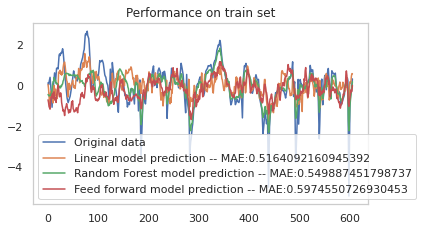

In [30]:
plt.title("Performance on train set")
plt.plot(train.iloc[:, -1].values, label='Original data')
plt.plot(linear_val.predict(train.iloc[:, :72].values), label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(train.iloc[:, :72].values), label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(train.iloc[:, :72].values), label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

In [31]:
linear_mae = mean_absolute_error(validation.iloc[:, -1].values, linear_val.predict(validation.iloc[:, :72].values))
rf_mae = mean_absolute_error(validation.iloc[:, -1].values, opt.predict(validation.iloc[:, :72].values))
ffnn_mae = mean_absolute_error(validation.iloc[:, -1].values, ffnn_val.predict(validation.iloc[:, :72].values))

In [32]:
linear_mse = mean_squared_error(validation.iloc[:, -1].values, linear_val.predict(validation.iloc[:, :72].values))
rf_mse = mean_squared_error(validation.iloc[:, -1].values, opt.predict(validation.iloc[:, :72].values))
ffnn_mse = mean_squared_error(validation.iloc[:, -1].values, ffnn_val.predict(validation.iloc[:, :72].values))

linear_mse, rf_mse, ffnn_mse

(0.8996629669531268, 0.0954208998279242, 0.33075381077268506)

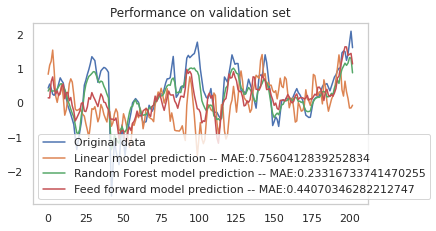

In [33]:
plt.title("Performance on validation set")
plt.plot(validation.iloc[:, -1].values, label='Original data')
plt.plot(linear_val.predict(validation.iloc[:, :72].values), label='Linear model prediction -- MAE:' + str(linear_mae))
plt.plot(opt.predict(validation.iloc[:, :72].values), label='Random Forest model prediction -- MAE:' + str(rf_mae))
plt.plot(ffnn_val.predict(validation.iloc[:, :72].values), label='Feed forward model prediction -- MAE:' + str(ffnn_mae))
plt.legend()
plt.show()

In [34]:
linear_mae = mean_absolute_error(test.iloc[:, -1].values, linear.predict(test.iloc[:, :72].values))
rf_mae = mean_absolute_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :72].values))
ffnn_mae = mean_absolute_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :72].values))

In [38]:
linear_mae, rf_mae, ffnn_mae

(0.5150616865834511, 0.549887451798737, 0.5974550726930453)

In [35]:
linear_mse = mean_squared_error(test.iloc[:, -1].values, linear.predict(test.iloc[:, :72].values))
rf_mse = mean_squared_error(test.iloc[:, -1].values, best_rf.predict(test.iloc[:, :72].values))
ffnn_mse = mean_squared_error(test.iloc[:, -1].values, ffnn.predict(test.iloc[:, :72].values))

linear_mse, rf_mse, ffnn_mse

(0.44367013385375875, 0.4532172904985963, 0.5676117294105825)

In [36]:
sqrt(linear_mse), sqrt(rf_mse), sqrt(ffnn_mse)

(0.6660856805650147, 0.673214149062983, 0.753400112430694)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


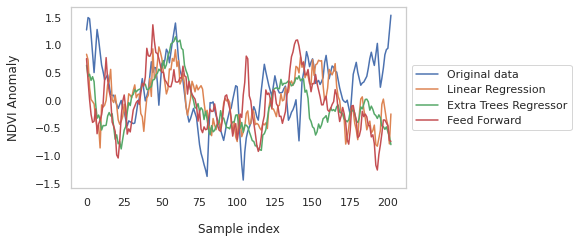

In [37]:

plt.plot(test.iloc[:, -1].values, label='Original data')
plt.plot(linear.predict(test.iloc[:, :72].values), label='Linear Regression')
plt.plot(best_rf.predict(test.iloc[:, :72].values), label='Extra Trees Regressor')
plt.plot(ffnn.predict(test.iloc[:, :72].values), label='Feed Forward')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Sample index',labelpad=15)
plt.ylabel('NDVI Anomaly',labelpad=15)
plt.savefig('imgs/regression_serie+storica+var.eps', format='eps', bbox_inches='tight')
plt.show()